# 4. Logistic Regression to Distingush Developing and Non-Developing TC seeds

This notebook will evaluate the skill of an ML model in distinguishing developing and non-developing TC seeds from the first four days since the identification of the disturbance.

1. Test a logistic regression model using 6 hourly data for three days
2. Test a logistic regression model using 6 hourly data for four days
3. Test a logistic regression model using hourly data for four days
4. Test a logistic regression model using TCWV>=45mm for the best of the above (hourly for four days)
5. Test a decision tree model for the best of the above (hourly for four days, TCWV>=50mm)

## Import statements

In [21]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             RocCurveDisplay, PrecisionRecallDisplay,
                             mean_squared_error, r2_score,
                             confusion_matrix, f1_score)
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score

## Load and process data

In [2]:
years_dev = np.arange(1981, 2020 + 1)
years_nondev = np.arange(1981, 2020 +1)

dev_list = [
    f"/data/keeling/a/smhenry2/Data/TCG/ERA5_processed_6hourly/developers_inner_outer_6hourly_{year}_ERA5.nc" for year in years_dev
]
nondev_list = [
    f"/data/keeling/a/smhenry2/Data/TCG/ERA5_processed_6hourly/non-developers_inner_outer_6hourly_16points_tcwv_{year}_ERA5.nc"
    for year in years_nondev
]

dev = xr.open_mfdataset(
    dev_list,
    combine="nested",
    concat_dim="track_point",
    join="outer"
).load()

nondev = xr.open_mfdataset(
    nondev_list,
    combine="nested",
    concat_dim="track_point",
    join="outer"
).load()

dev_list_hourly = [
    f"/data/keeling/a/smhenry2/Data/TCG/ERA5_processed_hourly/developers_inner_outer_6hourly_{year}_ERA5.nc" for year in years_dev
]

dev_list_hourly_valid = dev_list_hourly

nondev_list_hourly = [
    f"/data/keeling/a/smhenry2/Data/TCG/ERA5_processed_hourly/non-developers_inner_outer_hourly_16points_{year}_Jan-Apr_ERA5.nc"
    for year in years_nondev
] + [
    f"/data/keeling/a/smhenry2/Data/TCG/ERA5_processed_hourly/non-developers_inner_outer_hourly_16points_{year}_May-Aug_ERA5.nc"
    for year in years_nondev
] + [
    f"/data/keeling/a/smhenry2/Data/TCG/ERA5_processed_hourly/non-developers_inner_outer_hourly_16points_{year}_Sep-Dec_ERA5.nc"
    for year in years_nondev
]

nondev_list_hourly_valid = []

for f in nondev_list_hourly:
    try:
        xr.open_dataset(f, engine="netcdf4").close()
        nondev_list_hourly_valid.append(f)
    except Exception:
        pass

dev_hourly = xr.open_mfdataset(
    dev_list_hourly_valid,
    combine="nested",
    concat_dim="track_point",
    join="outer"
).load()

nondev_hourly = xr.open_mfdataset(
    nondev_list_hourly_valid,
    combine="nested",
    concat_dim="track_point",
    join="outer"
).load()


# define a function to filter out dry vorticies
def remove_dry_vortex(ds, threshold=50):
    # keep only IDs where max tcwv>=50
    max_tcwv = ds["tcwv"].groupby(ds["id"]).max()
    
    max_tcwv_computed = max_tcwv.compute()
    
    valid_ids = (
        max_tcwv_computed
        .where(max_tcwv_computed >= threshold, drop=True)
        .coords["id"]
        .values
    )
    
    mask = ds["id"].isin(valid_ids).compute()
    return ds.where(mask, drop=True)
    

# define a function to process the data
def process_data(ds, label, num_track=12):

    # process to keep just x num of track points

    groups = ds.groupby("id").groups
    valid_ids = [cid for cid, idx in groups.items() if len(idx) >= num_track]

    keep_indices = []
    for id in valid_ids:
        idx = groups[id][:num_track]
        keep_indices.extend(idx)

    keep_indices = np.array(keep_indices, dtype=int)   # <-- FIX
    keep_indices = np.sort(keep_indices)

    ds_processed = ds.isel(track_point=keep_indices)

    keep_vars = ["vo_925_inner", "conv_975_inner", "q_700_inner",
                 "vo_925_outer", "conv_975_outer", "q_700_outer",
                 "lat", "lon", "id", "time_dt"]
    ds_processed = ds_processed[keep_vars]

    # process to input and output

    groups = ds_processed.groupby("id")
    ids = list(groups.groups.keys())
    X_list = []
    y_list = []

    for id in ids:
        track = groups[id]

        arr = np.concatenate([
            track["vo_925_inner"].values,
            track["conv_975_inner"].values,
            track["q_700_inner"].values,
            track["vo_925_outer"].values,
            track["conv_975_outer"].values,
            track["q_700_outer"].values,
            track["lat"].values,
            track["lon"].values,
        ])

        X_list.append(arr)
        y_list.append(label)

    return np.array(X_list), np.array(y_list)


# filter out dry vorticies from the non-devlopers
nondev_wet_50mm = remove_dry_vortex(nondev)
nondev_wet_50mm_hourly = remove_dry_vortex(nondev_hourly)
nondev_wet_45mm_hourly = remove_dry_vortex(nondev_hourly, threshold=45)

In [31]:
# get input and outputs for 4 days developers, nondevelopers TCWV>=50mm, nondevelopers TCWV>=45mm
X_dev_4day, y_dev_4day = process_data(dev, 1, num_track=16)
X_nondev_50mm_4day, y_nondev_50mm_4day = process_data(nondev_wet_50mm, 0, num_track=16)

X_dev_4day_hourly, y_dev_4day_hourly = process_data(dev_hourly, 1, num_track=16)
X_nondev_50mm_4day_hourly, y_nondev_50mm_4day_hourly = process_data(nondev_wet_50mm_hourly, 0, num_track=16)
X_nondev_45mm_4day_hourly, y_nondev_45mm_4day_hourly = process_data(nondev_wet_45mm_hourly, 0, num_track=16)
# will need to make sure I'm using the right method for hourly data

# get input and outputs for 3 days developers, nondevelopers TCWV>=50mm, nondevelopers TCWV>=45mm
X_dev_3day, y_dev_3day = process_data(dev, 1, num_track=12)
X_nondev_50mm_3day, y_nondev_50mm_3day = process_data(nondev_wet_50mm, 0, num_track=12)
X_dev_3day_hourly, y_dev_3day_hourly = process_data(dev_hourly, 1, num_track=12)
X_nondev_50mm_3day_hourly, y_nondev_50mm_3day_hourly = process_data(nondev_wet_50mm_hourly, 0, num_track=12)

## Split into testing and training sets

In [33]:
X_50mm_4day = np.vstack([X_dev_4day, X_nondev_50mm_4day])
y_50mm_4day = np.concatenate([y_dev_4day, y_nondev_50mm_4day])

X_50mm_3day = np.vstack([X_dev_3day, X_nondev_50mm_3day])
y_50mm_3day = np.concatenate([y_dev_3day, y_nondev_50mm_3day])

X_50mm_4day_hourly = np.vstack([X_dev_4day_hourly, X_nondev_50mm_4day_hourly])
y_50mm_4day_hourly = np.concatenate([y_dev_4day_hourly, y_nondev_50mm_4day_hourly])

X_50mm_3day_hourly = np.vstack([X_dev_3day_hourly, X_nondev_50mm_3day_hourly])
y_50mm_3day_hourly = np.concatenate([y_dev_3day_hourly, y_nondev_50mm_3day_hourly])

X_45mm_4day_hourly = np.vstack([X_dev_4day_hourly, X_nondev_45mm_4day_hourly])
y_45mm_4day_hourly = np.concatenate([y_dev_4day_hourly, y_nondev_45mm_4day_hourly])


X_train_50mm_4day, X_test_50mm_4day, y_train_50mm_4day, y_test_50mm_4day = train_test_split(
    X_50mm_4day, y_50mm_4day, test_size=0.3, random_state=12)

X_train_50mm_3day, X_test_50mm_3day, y_train_50mm_3day, y_test_50mm_3day = train_test_split(
    X_50mm_3day, y_50mm_3day, test_size=0.3, random_state=12)

X_train_50mm_4day_hourly, X_test_50mm_4day_hourly, y_train_50mm_4day_hourly, y_test_50mm_4day_hourly = train_test_split(
    X_50mm_4day_hourly, y_50mm_4day_hourly, test_size=0.3, random_state=12)

X_train_50mm_3day_hourly, X_test_50mm_3day_hourly, y_train_50mm_3day_hourly, y_test_50mm_3day_hourly = train_test_split(
    X_50mm_3day_hourly, y_50mm_3day_hourly, test_size=0.3, random_state=12)

X_train_45mm_4day_hourly, X_test_45mm_4day_hourly, y_train_45mm_4day_hourly, y_test_45mm_4day_hourly = train_test_split(
    X_45mm_4day_hourly, y_45mm_4day_hourly, test_size=0.3, random_state=12)

## 1. Test a logistic regression model using 6 hourly data for three days

### Train the model

In [5]:
X_train = X_train_50mm_3day
y_train = y_train_50mm_3day
X_test = X_test_50mm_3day
y_test = y_test_50mm_3day

model = LogisticRegression(max_iter=10000, class_weight='balanced')
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

### Test the model

In [6]:
acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pred)

prec_train = precision_score(y_train, y_train_pred, zero_division=0)
prec_test = precision_score(y_test, y_test_pred, zero_division=0)

rec_train = recall_score(y_train, y_train_pred, zero_division=0)
rec_test = recall_score(y_test, y_test_pred, zero_division=0)

print("validation:")
print(f"Accuracy train: {acc_train}, Accuracy test: {acc_test}")
print(f"Precision train: {prec_train}, Precision test: {prec_test}")
print(f"Recall train: {rec_train}, Recall test: {rec_test}")

tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()

FAR = fp / (fp + tp) if (fp + tp) > 0 else 0
TNR = tn / (tn + fp) if (tn + fp) > 0 else 0

CSI = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0
f1 = f1_score(y_test, y_test_pred, zero_division=0)
print()
print(f"False Alarm Rate (FAR): {FAR}")
print(f"True Negative Rate (TNR): {TNR}")
print(f"False Positive Rate (FPR): {FPR}")
print(f"Critical Success Index (CSI): {CSI}")
print(f"F1 score: {f1}")

validation:
Accuracy train: 0.7474884604941624, Accuracy test: 0.7454084863837872
Precision train: 0.17183098591549295, Precision test: 0.17419354838709677
Recall train: 0.7922077922077922, Recall test: 0.8181818181818182

False Alarm Rate (FAR): 0.8258064516129032
Probability of False Detection (POFD): 0.2594594594594595
True Negative Rate (TNR): 0.7405405405405405
False Positive Rate (FPR): 0.2594594594594595
Critical Success Index (CSI): 0.16770186335403728
F1 score: 0.2872340425531915


### Visualize the results

ROC / PR curves:


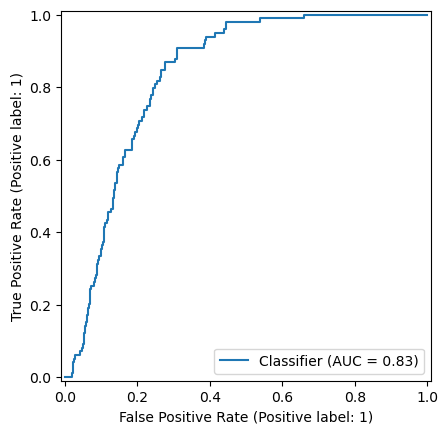

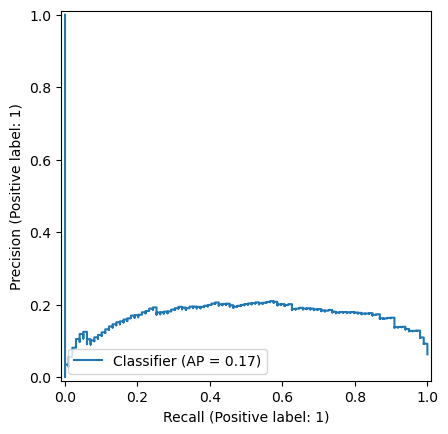

In [7]:
y_prob_train = model.predict_proba(X_train)[:, 1]
y_prob_test = model.predict_proba(X_test)[:, 1]
print("ROC / PR curves:")
RocCurveDisplay.from_predictions(y_test, y_prob_test)
PrecisionRecallDisplay.from_predictions(y_test, y_prob_test)

### Interpretation

- This is the baseline model, built on a simple linear regression with the simplest data (6 hourly, 3 days of track data).
- The accuracy (0.75) and recall (0.82) are strong, but the precision is not (0.17). Also, the FAR is high (0.83). This indicates that the model tries to succeed by over-identifying TCG cases.
- Improving the amount of data (from 3 days to 4 days) and the resolution (6-hourly to hourly) will likely improve the model.

## 2. Test a logistic regression model using 6 hourly data for four days

### Train the model

In [8]:
X_train = X_train_50mm_4day
y_train = y_train_50mm_4day
X_test = X_test_50mm_4day
y_test = y_test_50mm_4day

model = LogisticRegression(max_iter=10000, class_weight='balanced')
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

### Test the model

In [9]:
acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pred)

prec_train = precision_score(y_train, y_train_pred, zero_division=0)
prec_test = precision_score(y_test, y_test_pred, zero_division=0)

rec_train = recall_score(y_train, y_train_pred, zero_division=0)
rec_test = recall_score(y_test, y_test_pred, zero_division=0)

print("validation:")
print(f"Accuracy train: {acc_train}, Accuracy test: {acc_test}")
print(f"Precision train: {prec_train}, Precision test: {prec_test}")
print(f"Recall train: {rec_train}, Recall test: {rec_test}")

tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()

FAR = fp / (fp + tp) if (fp + tp) > 0 else 0
TNR = tn / (tn + fp) if (tn + fp) > 0 else 0
FPR = fp / (fp + tn) if (fp + tn) > 0 else 0
CSI = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0
f1 = f1_score(y_test, y_test_pred, zero_division=0)
print()
print(f"False Alarm Rate (FAR): {FAR}")
print(f"True Negative Rate (TNR): {TNR}")
print(f"False Positive Rate (FPR): {FPR}")
print(f"Critical Success Index (CSI): {CSI}")
print(f"F1 score: {f1}")

validation:
Accuracy train: 0.7300242130750605, Accuracy test: 0.704331450094162
Precision train: 0.1895674300254453, Precision test: 0.16034985422740525
Recall train: 0.8232044198895028, Recall test: 0.6790123456790124

False Alarm Rate (FAR): 0.8396501457725948
Probability of False Detection (POFD): 0.29357798165137616
True Negative Rate (TNR): 0.7064220183486238
False Positive Rate (FPR): 0.29357798165137616
Critical Success Index (CSI): 0.14905149051490515
F1 score: 0.25943396226415094


### Visualize the results

ROC / PR curves:


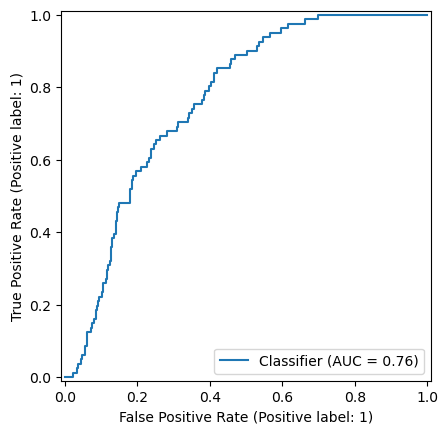

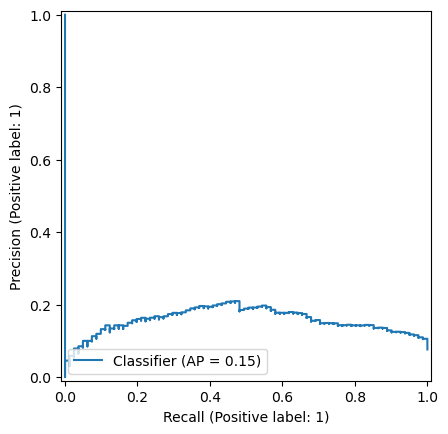

In [10]:
y_prob_train = model.predict_proba(X_train)[:, 1]
y_prob_test = model.predict_proba(X_test)[:, 1]
print("ROC / PR curves:")
RocCurveDisplay.from_predictions(y_test, y_prob_test)
PrecisionRecallDisplay.from_predictions(y_test, y_prob_test)

### Interpretation

- This model is the next step up from the baseline, where an extra day of data is used (3 days to 4 days).
- Surprisingly, this model (model 2) is not as good as model 1. This is unexpected because the differencs between developers and non-developers grow exponentially with time as seen in the visualization notebook. The best interpretation on why this could be is that the 700-hPa specific humidity in the outer region for developers decreases slightly around hour 60.
- The accuracy (0.70) and precision (0.16) are stable between testing and training, but the recall (0.68) is not. FAR (0.84) and FPR (0.29) are all higher for model 2 than model 1.

## 3. Test a logistic regression model using hourly data for four days

### Train the model

In [36]:
X_train = X_train_50mm_4day_hourly
y_train = y_train_50mm_4day_hourly
X_test = X_test_50mm_4day_hourly
y_test = y_test_50mm_4day_hourly

model = LogisticRegression(max_iter=10000, class_weight='balanced')
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

### Test the model

In [37]:
acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pred)

prec_train = precision_score(y_train, y_train_pred, zero_division=0)
prec_test = precision_score(y_test, y_test_pred, zero_division=0)

rec_train = recall_score(y_train, y_train_pred, zero_division=0)
rec_test = recall_score(y_test, y_test_pred, zero_division=0)

print("validation:")
print(f"Accuracy train: {acc_train}, Accuracy test: {acc_test}")
print(f"Precision train: {prec_train}, Precision test: {prec_test}")
print(f"Recall train: {rec_train}, Recall test: {rec_test}")

tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()

FAR = fp / (fp + tp) if (fp + tp) > 0 else 0
TNR = tn / (tn + fp) if (tn + fp) > 0 else 0

CSI = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0
f1 = f1_score(y_test, y_test_pred, zero_division=0)
print()
print(f"False Alarm Rate (FAR): {FAR}")
print(f"True Negative Rate (TNR): {TNR}")
print(f"False Positive Rate (FPR): {FPR}")
print(f"Critical Success Index (CSI): {CSI}")
print(f"F1 score: {f1}")

validation:
Accuracy train: 0.7654091939806226, Accuracy test: 0.757094757094757
Precision train: 0.17578125, Precision test: 0.175
Recall train: 0.7305194805194806, Recall test: 0.6950354609929078

False Alarm Rate (FAR): 0.825
Probability of False Detection (POFD): 0.23839009287925697
True Negative Rate (TNR): 0.7616099071207431
False Positive Rate (FPR): 0.23839009287925697
Critical Success Index (CSI): 0.1625207296849088
F1 score: 0.2796005706134094


### Visualize the results

ROC / PR curves:


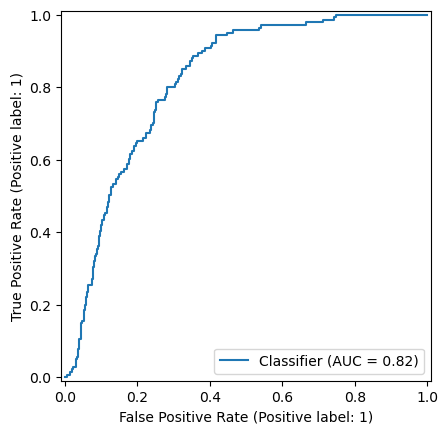

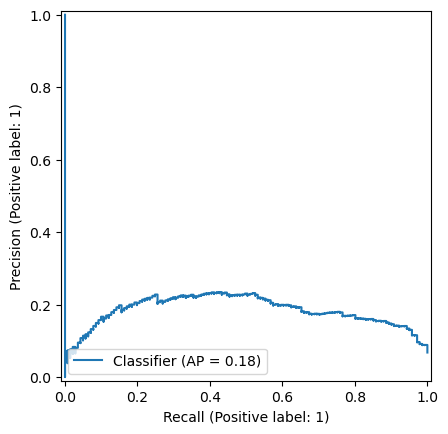

In [38]:
y_prob_train = model.predict_proba(X_train)[:, 1]
y_prob_test = model.predict_proba(X_test)[:, 1]
print("ROC / PR curves:")
RocCurveDisplay.from_predictions(y_test, y_prob_test)
PrecisionRecallDisplay.from_predictions(y_test, y_prob_test)

### Interpretation

- Model 3 performs better than models 1 and 2 due to greater detail in data, providing more information for the model to learn from.
- Accuracy (0.76), precision (0.18) and recall (0.70) are similar to models 1 and 2, but FAR (0.83) and FPR (0.24) are similar to model 1 but better than model 2.
- The AUC (0.82) and AP (0.18) are higher for model 3 than model 2 and similar to model 1.
- Model 3 still performs better than model 1 becuase: fewer false positives, slightly higher accuracy, better rejection of non-developers.

## 4. Test a logistic regression model using TCWV>=45mm for the best of the above
- Hourly data

### Train the model

In [14]:
X_train = X_train_45mm_4day_hourly
y_train = y_train_45mm_4day_hourly
X_test = X_test_45mm_4day_hourly
y_test = y_test_45mm_4day_hourly

model = LogisticRegression(max_iter=10000, class_weight='balanced')
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

### Test the model

In [15]:
acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pred)

prec_train = precision_score(y_train, y_train_pred, zero_division=0)
prec_test = precision_score(y_test, y_test_pred, zero_division=0)

rec_train = recall_score(y_train, y_train_pred, zero_division=0)
rec_test = recall_score(y_test, y_test_pred, zero_division=0)

print("validation:")
print(f"Accuracy train: {acc_train}, Accuracy test: {acc_test}")
print(f"Precision train: {prec_train}, Precision test: {prec_test}")
print(f"Recall train: {rec_train}, Recall test: {rec_test}")

tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()

FAR = fp / (fp + tp) if (fp + tp) > 0 else 0
TNR = tn / (tn + fp) if (tn + fp) > 0 else 0

CSI = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0
f1 = f1_score(y_test, y_test_pred, zero_division=0)
print()
print(f"False Alarm Rate (FAR): {FAR}")
print(f"True Negative Rate (TNR): {TNR}")
print(f"False Positive Rate (FPR): {FPR}")
print(f"Critical Success Index (CSI): {CSI}")
print(f"F1 score: {f1}")

validation:
Accuracy train: 0.7464860287891617, Accuracy test: 0.7340971947846701
Precision train: 0.14173228346456693, Precision test: 0.12845303867403315
Recall train: 0.7452229299363057, Recall test: 0.6888888888888889

False Alarm Rate (FAR): 0.8715469613259669
Probability of False Detection (POFD): 0.26335559265442404
True Negative Rate (TNR): 0.736644407345576
False Positive Rate (FPR): 0.26335559265442404
Critical Success Index (CSI): 0.12140992167101827
F1 score: 0.21653084982537835


### Visualize the results

ROC / PR curves:


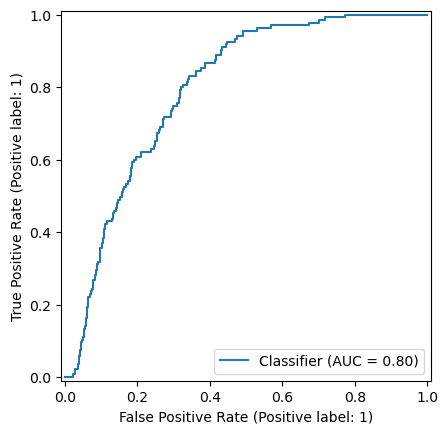

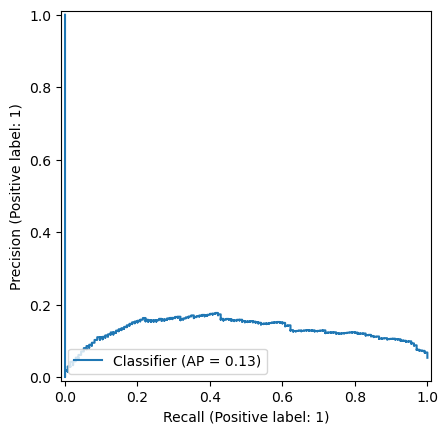

In [16]:
y_prob_train = model.predict_proba(X_train)[:, 1]
y_prob_test = model.predict_proba(X_test)[:, 1]
print("ROC / PR curves:")
RocCurveDisplay.from_predictions(y_test, y_prob_test)
PrecisionRecallDisplay.from_predictions(y_test, y_prob_test)

### Interpretation

- Based on the reduction of the treshold for TCWV, I would expect this model to perform better. This is because with a lower threshold the specific humidity data are more different between developers and non-developers than with a higher treshold.
- However, this model does not perform better than the respective model 3. Compared to model 3, it has lower accuracy (0.73), precision (0.13), and recall (0.69) and higher FAR (0.87) and FPR (0.26). Perhaps this is due to an adjusted sample size between the two tresholds.
- This indicates that the TCWV threshold of 50 mm is more adequate and does not result in a weaker model performace.

## 5. Test a decision tree model for the best of the above
- Hourly data
- 4 days
- TCWV>=50mm

## Train the model

In [24]:
X_train = X_train_50mm_4day_hourly
y_train = y_train_50mm_4day_hourly
X_test  = X_test_50mm_4day_hourly
y_test  = y_test_50mm_4day_hourly

tree = DecisionTreeClassifier(
    max_depth=5,
    min_samples_leaf=10,
    class_weight="balanced",
    random_state=42
)

tree.fit(X_train, y_train)

y_train_pred = tree.predict(X_train)
y_test_pred  = tree.predict(X_test)

### Test the model

In [26]:
acc_train = accuracy_score(y_train, y_train_pred)
acc_test  = accuracy_score(y_test, y_test_pred)

prec_train = precision_score(y_train, y_train_pred, zero_division=0)
prec_test  = precision_score(y_test, y_test_pred, zero_division=0)

rec_train = recall_score(y_train, y_train_pred, zero_division=0)
rec_test  = recall_score(y_test, y_test_pred, zero_division=0)

print("validation:")
print(f"Accuracy train: {acc_train}, Accuracy test: {acc_test}")
print(f"Precision train: {prec_train}, Precision test: {prec_test}")
print(f"Recall train: {rec_train}, Recall test: {rec_test}")

tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()

FAR  = fp / (fp + tp) if (fp + tp) > 0 else 0
TNR  = tn / (tn + fp) if (tn + fp) > 0 else 0
FPR  = fp / (fp + tn) if (fp + tn) > 0 else 0
CSI  = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0
f1   = f1_score(y_test, y_test_pred, zero_division=0)

print()
print(f"False Alarm Rate (FAR): {FAR}")
print(f"True Negative Rate (TNR): {TNR}")
print(f"False Positive Rate (FPR): {FPR}")
print(f"Critical Success Index (CSI): {CSI}")
print(f"F1 score: {f1}")


validation:
Accuracy train: 0.9649556792413936, Accuracy test: 0.9437229437229437
Precision train: 0.65, Precision test: 0.558252427184466
Recall train: 0.9707792207792207, Recall test: 0.8156028368794326

False Alarm Rate (FAR): 0.441747572815534
Probability of False Detection (POFD): 0.04695562435500516
True Negative Rate (TNR): 0.9530443756449949
False Positive Rate (FPR): 0.04695562435500516
Critical Success Index (CSI): 0.4956896551724138
F1 score: 0.6628242074927954


### Visualize the results

ROC / PR curves:


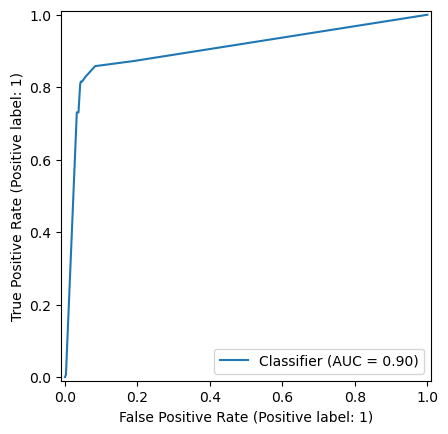

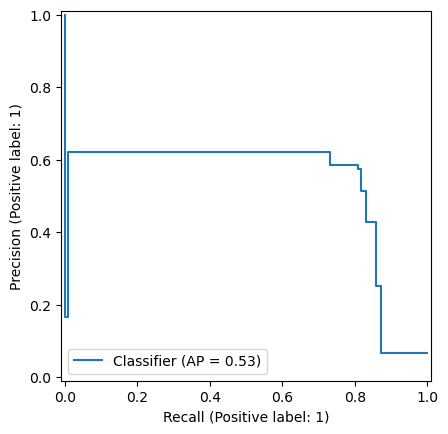

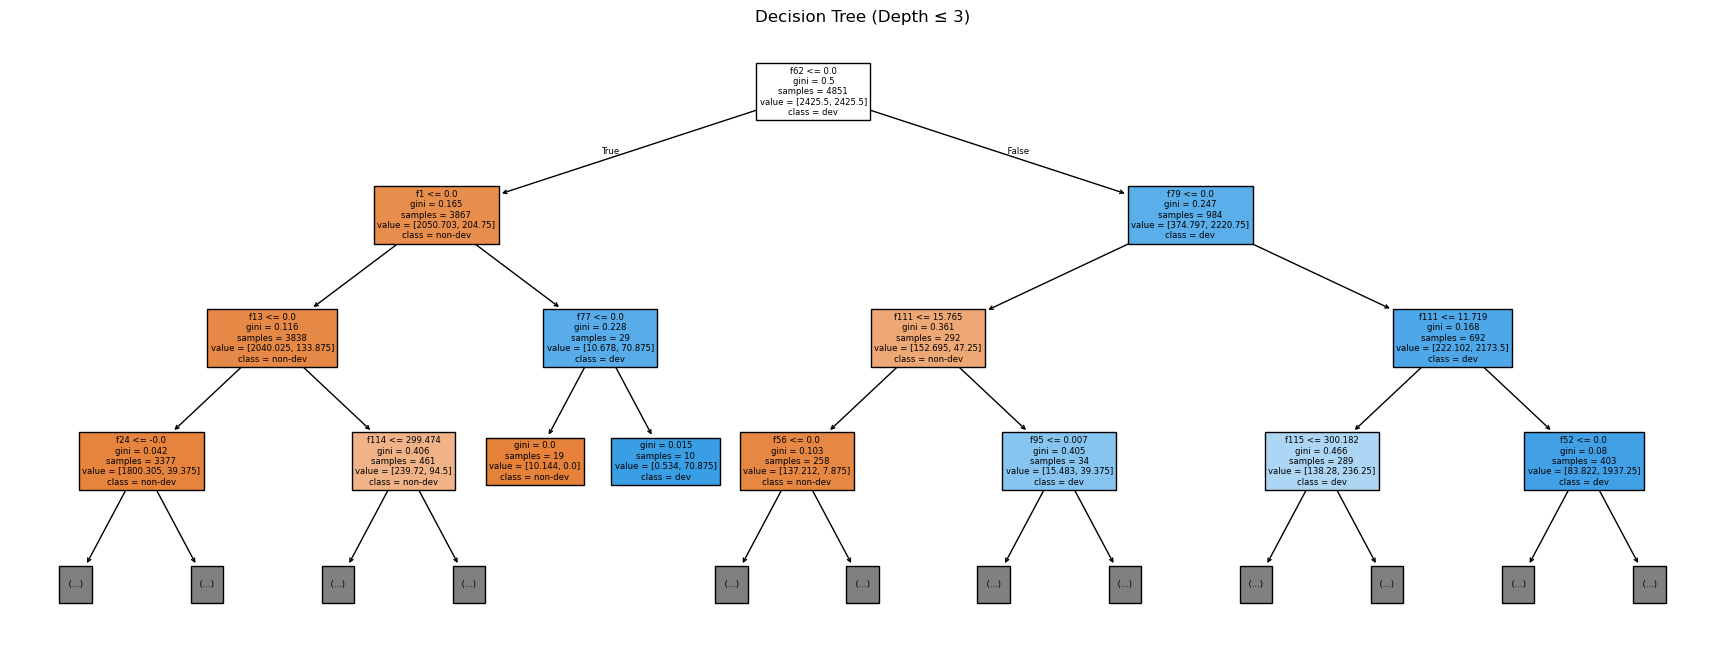

In [27]:
y_prob_train = tree.predict_proba(X_train)[:, 1]
y_prob_test  = tree.predict_proba(X_test)[:, 1]

print("ROC / PR curves:")
RocCurveDisplay.from_predictions(y_test, y_prob_test)
PrecisionRecallDisplay.from_predictions(y_test, y_prob_test)


plt.figure(figsize=(22, 8))
plot_tree(
    tree,
    max_depth=3,
    filled=True,
    feature_names=[f"f{i}" for i in range(X_train.shape[1])],
    class_names=["non-dev", "dev"]
)
plt.title("Decision Tree (Depth ≤ 3)")
plt.show()


### Interpretation

- The decision tree is remarkably better than the linear regression models, with higher accuracy (0.94), precision (0.55), and recall (0.82) and a lower FAR (0.44) and FPR (0.05).
- Especially notable are the higher precision and lower FPR, indicating that the model can accurately detect when a developer is a developer, but still identifies some non-developers as developers.
- Recall is not stable between testing and training, indicating some overfitting, but precision and accuracy are stable.
- More diagnosis could be done to evaluatae the decision tree's performance and the way it is structured.